In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import norm
from pyDOE import lhs
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#create a NN architecture

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.hiddenlayers = nn.Sequential(
        nn.Linear(5, 64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,1)
        )

    def forward(self, X):
        return self.hiddenlayers(X)

model = NN()

In [ ]:


def BSM_loss(model, X_f, X_T, X_lb, X_ub, T, S_max,
             lambda_pde=1.0, lambda_T=10.0, lambda_bc=10.0,
             option_type='call'):
    """
    PINN Loss for European Call or Put Options under BSM.
    ------------------------------------------------------
    model: neural network approximating V(t, S, r, sigma, K)
    option_type: 'call' or 'put'
    """

    # ========== PDE Residual ==========
    X_f.requires_grad = True
    V_pred = model(X_f)

    t_f = X_f[:, 0:1]
    S_f = X_f[:, 1:2]
    r_f = X_f[:, 2:3]
    sigma_f = X_f[:, 3:4]

    grads = torch.autograd.grad(V_pred.sum(), X_f, create_graph=True)[0]
    V_t = grads[:, 0:1]
    V_S = grads[:, 1:2]
    V_SS = torch.autograd.grad(V_S.sum(), X_f, create_graph=True)[0][:, 1:2]

    # PDE Residual: ∂V/∂t + ½σ²S²∂²V/∂S² + rS∂V/∂S - rV = 0
    residual = V_t + 0.5 * sigma_f**2 * S_f**2 * V_SS + r_f * S_f * V_S - r_f * V_pred
    pde_loss = torch.mean(residual**2)

    # ========== Terminal Condition ==========
    S_T = X_T[:, 1:2]
    K_T = X_T[:, 4:5]

    if option_type == 'call':
        payoff = torch.clamp(S_T - K_T, min=0.0)
    elif option_type == 'put':
        payoff = torch.clamp(K_T - S_T, min=0.0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    V_T_pred = model(X_T)
    terminal_loss = torch.mean((V_T_pred - payoff)**2)

    # ========== Boundary Conditions ==========

    # Left boundary: S = 0
    V_lb_pred = model(X_lb)
    if option_type == 'call':
        left_bc_target = torch.zeros_like(V_lb_pred)
    else:  # put
        K_lb = X_lb[:, 4:5]
        left_bc_target = K_lb * torch.exp(-r_f * (T - X_lb[:, 0:1]))
    left_bc_loss = torch.mean((V_lb_pred - left_bc_target)**2)

    # Right boundary: S = S_max
    t_ub = X_ub[:, 0:1]
    S_ub = X_ub[:, 1:2]
    r_ub = X_ub[:, 2:3]
    K_ub = X_ub[:, 4:5]
    V_ub_pred = model(X_ub)

    if option_type == 'call':
        right_bc_target = S_ub - K_ub * torch.exp(-r_ub * (T - t_ub))
    else:  # put
        right_bc_target = torch.zeros_like(V_ub_pred)
    right_bc_loss = torch.mean((V_ub_pred - right_bc_target)**2)

    # ========== Total Loss ==========
    total_loss = (
        lambda_pde * pde_loss +
        lambda_T * terminal_loss +
        lambda_bc * (left_bc_loss + right_bc_loss)
    )

    return total_loss, pde_loss.item(), terminal_loss.item(), left_bc_loss.item(), right_bc_loss.item()


In [ ]:
def BSM_loss_american(model, X_f, X_T, X_lb, X_ub, T, S_max,
                      lambda_pde=1.0, lambda_T=10.0, lambda_bc=10.0, lambda_ex=10.0,
                      option_type='put'):
    """
    PINN Loss for American Options (default: Put).
    Adds early exercise constraint: V >= payoff(S).
    """

    # PDE Residual (same as European)
    X_f.requires_grad = True
    V_pred = model(X_f)
    t_f = X_f[:, 0:1]
    S_f = X_f[:, 1:2]
    r_f = X_f[:, 2:3]
    sigma_f = X_f[:, 3:4]

    grads = torch.autograd.grad(V_pred.sum(), X_f, create_graph=True)[0]
    V_t = grads[:, 0:1]
    V_S = grads[:, 1:2]
    V_SS = torch.autograd.grad(V_S.sum(), X_f, create_graph=True)[0][:, 1:2]

    residual = V_t + 0.5 * sigma_f**2 * S_f**2 * V_SS + r_f * S_f * V_S - r_f * V_pred
    pde_loss = torch.mean(residual**2)

    # Terminal Condition
    S_T = X_T[:, 1:2]
    K_T = X_T[:, 4:5]
    if option_type == 'call':
        payoff = torch.clamp(S_T - K_T, min=0.0)
    else:
        payoff = torch.clamp(K_T - S_T, min=0.0)
    V_T_pred = model(X_T)
    terminal_loss = torch.mean((V_T_pred - payoff)**2)

    # Boundary Conditions
    V_lb_pred = model(X_lb)
    if option_type == 'call':
        left_bc_target = torch.zeros_like(V_lb_pred)
    else:
        K_lb = X_lb[:, 4:5]
        left_bc_target = K_lb * torch.exp(-r_f * (T - X_lb[:, 0:1]))
    left_bc_loss = torch.mean((V_lb_pred - left_bc_target)**2)

    t_ub = X_ub[:, 0:1]
    S_ub = X_ub[:, 1:2]
    r_ub = X_ub[:, 2:3]
    K_ub = X_ub[:, 4:5]
    V_ub_pred = model(X_ub)
    if option_type == 'call':
        right_bc_target = S_ub - K_ub * torch.exp(-r_ub * (T - t_ub))
    else:
        right_bc_target = torch.zeros_like(V_ub_pred)
    right_bc_loss = torch.mean((V_ub_pred - right_bc_target)**2)

    # Early exercise penalty
    payoff_all = torch.clamp(K_T - S_f, min=0.0) if option_type == 'put' else torch.clamp(S_f - K_T, min=0.0)
    exercise_loss = torch.mean(torch.relu(payoff_all - V_pred)**2)

    # Total Loss
    total_loss = (
        lambda_pde * pde_loss +
        lambda_T * terminal_loss +
        lambda_bc * (left_bc_loss + right_bc_loss) +
        lambda_ex * exercise_loss
    )

    return total_loss, pde_loss.item(), terminal_loss.item(), left_bc_loss.item(), right_bc_loss.item(), exercise_loss.item()


In [5]:
# Stock price and time domain
S_min, S_max = 0.0, 200.0
T_min, T_max = 0.0, 1.0  # time in years

# Parameter ranges
r_range = [0.01, 0.1]        # risk-free rate
sigma_range = [0.1, 0.5]     # volatility
K_range = [50, 150]          # strike price

# Number of points
N_f = 10000      # PDE interior points
N_T = 1000       # Terminal points
N_lb = 1000      # Left boundary (S=0)
N_ub = 1000      # Right boundary (S=S_max)

In [6]:
lhs_samples = lhs(5, N_f)  # 5 inputs: t, S, r, sigma, K
t_f = T_min + (T_max - T_min) * lhs_samples[:, 0:1]
S_f = S_min + (S_max - S_min) * lhs_samples[:, 1:2]
r_f = r_range[0] + (r_range[1] - r_range[0]) * lhs_samples[:, 2:3]
sigma_f = sigma_range[0] + (sigma_range[1] - sigma_range[0]) * lhs_samples[:, 3:4]
K_f = K_range[0] + (K_range[1] - K_range[0]) * lhs_samples[:, 4:5]

X_f = torch.tensor(np.hstack([t_f, S_f, r_f, sigma_f, K_f]), dtype=torch.float32)

In [7]:
S_T = np.random.uniform(S_min, S_max, (N_T, 1))
r_T = np.random.uniform(r_range[0], r_range[1], (N_T, 1))
sigma_T = np.random.uniform(sigma_range[0], sigma_range[1], (N_T, 1))
K_T = np.random.uniform(K_range[0], K_range[1], (N_T, 1))
t_T = T_max * np.ones((N_T, 1))

X_T = torch.tensor(np.hstack([t_T, S_T, r_T, sigma_T, K_T]), dtype=torch.float32)

In [8]:
t_lb = np.random.uniform(T_min, T_max, (N_lb, 1))
S_lb = np.zeros((N_lb, 1))
r_lb = np.random.uniform(r_range[0], r_range[1], (N_lb, 1))
sigma_lb = np.random.uniform(sigma_range[0], sigma_range[1], (N_lb, 1))
K_lb = np.random.uniform(K_range[0], K_range[1], (N_lb, 1))

X_lb = torch.tensor(np.hstack([t_lb, S_lb, r_lb, sigma_lb, K_lb]), dtype=torch.float32)

In [9]:
t_ub = np.random.uniform(T_min, T_max, (N_ub, 1))
S_ub = S_max * np.ones((N_ub, 1))
r_ub = np.random.uniform(r_range[0], r_range[1], (N_ub, 1))
sigma_ub = np.random.uniform(sigma_range[0], sigma_range[1], (N_ub, 1))
K_ub = np.random.uniform(K_range[0], K_range[1], (N_ub, 1))

X_ub = torch.tensor(np.hstack([t_ub, S_ub, r_ub, sigma_ub, K_ub]), dtype=torch.float32)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000
print_every = 500

for epoch in range(1, epochs+1):
    optimizer.zero_grad()

    # Compute total loss and components
    total_loss, pde_loss, terminal_loss, left_bc_loss, right_bc_loss = BSM_loss(
        model, X_f, X_T, X_lb, X_ub, T=T_max, S_max=S_max,
        lambda_pde=1.0, lambda_T=10.0, lambda_bc=10.0
    )

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Print progress
    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:04d} | Total Loss: {total_loss.item():.6f} | "
              f"PDE: {pde_loss:.6f}, Terminal: {terminal_loss:.6f}, "
              f"Left BC: {left_bc_loss:.6f}, Right BC: {right_bc_loss:.6f}")

Epoch 0001 | Total Loss: 109361.250000 | PDE: 0.015857, Terminal: 1628.437500, Left BC: 2.275175, Right BC: 9305.410156
Epoch 0500 | Total Loss: 59.288876 | PDE: 11.144429, Terminal: 0.773019, Left BC: 0.028931, Right BC: 4.012495
Epoch 1000 | Total Loss: 36.982254 | PDE: 5.938542, Terminal: 0.375194, Left BC: 0.022215, Right BC: 2.706963
Epoch 1500 | Total Loss: 27.921913 | PDE: 4.290732, Terminal: 0.247611, Left BC: 0.006691, Right BC: 2.108816
Epoch 2000 | Total Loss: 23.891928 | PDE: 4.130654, Terminal: 0.140226, Left BC: 0.001893, Right BC: 1.834008
Epoch 2500 | Total Loss: 21.304840 | PDE: 4.181490, Terminal: 0.094884, Left BC: 0.001930, Right BC: 1.615521
Epoch 3000 | Total Loss: 19.822666 | PDE: 4.254797, Terminal: 0.106144, Left BC: 0.001835, Right BC: 1.448808
Epoch 3500 | Total Loss: 18.611652 | PDE: 4.260061, Terminal: 0.135061, Left BC: 0.001650, Right BC: 1.298448
Epoch 4000 | Total Loss: 17.725716 | PDE: 4.226610, Terminal: 0.170684, Left BC: 0.001551, Right BC: 1.177675

In [11]:
def bs_price(S, K, T, t, r, sigma):
    from scipy.stats import norm
    import numpy as np

    tau = T - t
    tau = np.maximum(tau, 1e-10)  # avoid zero division
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    price = S * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)
    price[S <= 0] = 0.0  # handle S=0
    return price

In [12]:
n_S_test, n_t_test, n_r_test, n_sigma_test, n_K_test = 50, 50, 3, 3, 3

S_test = np.linspace(S_min, S_max, n_S_test)
t_test = np.linspace(T_min, T_max, n_t_test)
r_test = np.linspace(r_range[0], r_range[1], n_r_test)
sigma_test = np.linspace(sigma_range[0], sigma_range[1], n_sigma_test)
K_test = np.linspace(K_range[0], K_range[1], n_K_test)

# Create meshgrid
mesh = np.array(np.meshgrid(t_test, S_test, r_test, sigma_test, K_test, indexing='ij'))
X_test = mesh.reshape(5, -1).T  # shape: [num_test_points, 5]
X_test = torch.tensor(X_test, dtype=torch.float32)

X_test_np = X_test.numpy()

In [13]:
model.eval()
with torch.no_grad():
    V_pred_test = model(X_test).cpu().numpy()

X_test_np = X_test.numpy()
S_test_vals = X_test_np[:, 1]
t_test_vals = X_test_np[:, 0]
r_test_vals = X_test_np[:, 2]
sigma_test_vals = X_test_np[:, 3]
K_test_vals = X_test_np[:, 4]

V_true_test = bs_price(S_test_vals, K_test_vals, T_max, t_test_vals, r_test_vals, sigma_test_vals)

/tmp/ipykernel_17322/4259886069.py:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))


In [14]:
rmse = np.sqrt(mean_squared_error(V_true_test, V_pred_test))
r2 = r2_score(V_true_test, V_pred_test)
print(f"Test RMSE: {rmse:.6f} | R² Score: {r2:.6f}")

Test RMSE: 4.016766 | R² Score: 0.990525


In [15]:
print(len(S_test_vals), len(np.unique(S_test_vals)))

67500 50


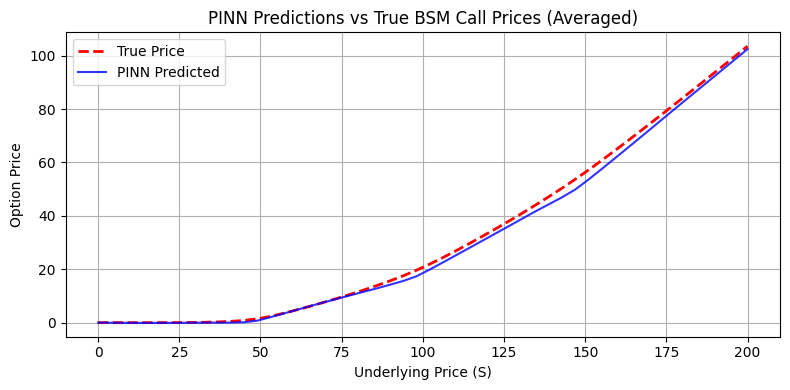

In [16]:
import numpy as np
import matplotlib.pyplot as plt

S = np.array(S_test_vals).squeeze()
V_true = np.array(V_true_test).squeeze()
V_pred = np.array(V_pred_test).squeeze()

# Group by unique S
S_unique = np.unique(S)
V_true_mean = [V_true[S == s].mean() for s in S_unique]
V_pred_mean = [V_pred[S == s].mean() for s in S_unique]

# Plot smooth averaged curve
plt.figure(figsize=(8, 4))
plt.plot(S_unique, V_true_mean, 'r--', label="True Price", linewidth=2)
plt.plot(S_unique, V_pred_mean, 'b', alpha=0.8, label="PINN Predicted", linewidth=1.5)
plt.xlabel("Underlying Price (S)")
plt.ylabel("Option Price")
plt.title("PINN Predictions vs True BSM Call Prices (Averaged)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
torch.save(model.state_dict(), "model.pt")

In [32]:
import pandas as pd
predictions = pd.DataFrame({ 'Asset_Price' : S_unique,
                             'True_OptionPrice' : V_true_mean,
                             'Predicted_OptionPrice_PINN': V_pred_mean })

In [34]:
predictions.to_csv("predictions.csv", index = False )